## Week 3: Linear Regression - part II

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

---
#### ``Objectives:``
1.  you will use a real dataset to **predict COVID-19 growth rates of cumulative cases** during the first wave of the pandemic<br>
2. work with panel data (contains geospatial and time information) <br>
3. perform outcome and feature engineering:
    - create outcome from exisiting data: i.e., define growth rates of COVID-19 cumulative cases <br>
    - create new features from existing data: categorical (one-hot encodings) and continous (rolling averages of human mobility) <br>
    - visualize distributions and correlations of features and outcome
4. perform non-random split between training and test data (remember the data has a time dimension!) <br>
5. train a **baseline** and a **mobility** model using: <br>
    - a closed-form solution for linear regression using statsmodels, and
    - an interative solution (gradient descent) using Tensorflow
6. evaluate and plot the performance of the two models

---
#### ``Data:``

The data is at the country-day level (panel) and provides information on:
* COVID-19 cumulative case numbers
* Google residential mobility


The data is publically available here:
 - Covid-19 cumulative cases: https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6 
 - Residential mobility: https://www.google.com/covid19/mobility/data_documentation.html

But to make it easier for you, we combined these data sources in the``03 Features.csv`` file. 

**Data dictionary**:

* adm0_name: administrative region 0 (i.e., country name)
* date: date of COVID-19 cumulative cases and mobility data
* day_of_week: day of week in date (Monday=0, etc...)
* cum_cases: cumulative number of COVID-19 cases at a given point in time
* mob_resid: percentage change in residential mobility compared to a baseline period. This baseline is defined as the median value for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020; see [here](https://www.google.com/covid19/mobility/data_documentation.html) for more information

---
### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

### Step 2: Define functions

``plots``

In [2]:
def pct_error_plot(df_b, df_m, plot_type, solution):
    """ Plot relationship between (forecast length, training length) and pct_error
    
    params:
    -------
    df_b: df, predictions using test data for baseline model
    df_m: df, predictions using test data for mobility model
    plot_type: str, you can choose between 'violin', 'box'
    solution: str, 'closed_form' or 'tf'
    
    return:
    -------
    plot
    """

    if solution=='closed_form':
        # add test predictions from both models, baseline and mobility
        df_b['model'] = 'baseline'
        df_m['model'] = "mobility"

        df = pd.concat(
            [df_b, df_m],
            axis=0
        )
    
    if solution=='tf':
        # keep only test test predictions for baseline model
        df = df_b
    
    # add length of forecast (in days) variable
    df['pred_day'] = df.groupby(
        ['adm0_name', 'model'],
        as_index = False)['date'].cumcount() #we have 10 days in forecast (test), this will start count at 0
    
    df['pred_day'] = df['pred_day'] + 1 #starts count at one now
    
    # initialize new figure
    sns.set(rc={'figure.figsize':(5,5)})
    
    
    # plot axes
    ax = sns.catplot(
        x='pred_day',
        y='pct_error',
        hue='model',
        data=df,
        kind=plot_type,
        palette='muted',
        legend=False
    )
    
    # set figure size
    ax.fig.set_figwidth(10)
    ax.fig.set_figheight(6)

    # set title, axes
    plt.title(
        'Percentage error in predicted number of cases at the country level \n train_length = 20 days',
        fontsize = 16
    )
    
    plt.ylabel('pct_error')
    plt.xlabel('length of forecast (days)')
    
    if solution=='baseline':
        ax.set(ylim=(-75, 75))
    
    # add vertical line at y=0
    plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
    
    # set legend
    legend = plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=10,
        prop={'size': 10}
    )
    
    return df

---
### Step 3: Read data
---

In [3]:
# read data (03 Features.csv)
url='https://drive.google.com/file/d/1yaF8ImJ2h64CedkKDq56P6iQmJAsZQJW/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

init_df = pd.read_csv(url)


# print shape of df, number of countries, and time period covered
print(
    'Shape of data: ',
    init_df.shape
)

print(
    'Number of counties: ',
    len(init_df.adm0_name.unique())
)

print(
    'Time period covered:',
    init_df.date.min(), 'to',
    init_df.date.max()
)
init_df.head(2)

Shape of data:  (19552, 5)
Number of counties:  188
Time period covered: 2020-02-16 to 2020-05-29


,adm0_name,date,day_of_week,cum_cases,mob_resid
0,Afghanistan,2020-02-16,6,0,0.0
1,Afghanistan,2020-02-17,0,0,-1.0


Our data contains information on COVID-19 cumulative cases and residential mobility for 188 counties in the world. The time period is between 2020-02-16 and 2020-05-29 (this corresponds with the first wave of the pandemic).

Because not all countries began testing for COVID-19 on the same date, these samples are unbalanced panels.

There are not too many features to choose from (see shape of data) but you can create additional ones using the exisiting data (we will do this in the Data preprocessing step below).

---
### Step 4: Data preprocessing
---

The quality of the data and the time we put into preprocessing it are very good determinants of how well our machine learning algorithm can learn. In the next subsections we will implement essential data preprocessing steps. Note that there are general rules on where one should start but keep in mind that this step often requires knowledge of the domain of study.

##### ``Step 4.1. Create outcome variable``

We are interested to predict the **growth rate of COVID-19 cumulative cases**. This is going to be our outcome variable (denote it 'D_ln_cum_cases'). It's defined as follows:

$D\_ln\_cum\_cases = \frac{cum\_cases_{t+1} - cum\_cases_{t}}{cum\_cases_{t}} = ln(\frac{cum\_cases_{t+1}}{cum\_cases_{t}}) = ln(cum\_cases_{t+1}) - ln(cum\_cases_{t})$

In [4]:
## define outcome variable ##
#############################

# define log of cum_cases
init_df['ln_cum_cases'] = np.log(
    init_df.cum_cases
)
    
# one period difference of log of cum_cases (remember that we need to do this for each country separately! groupby is esential here)
init_df['D_ln_cum_cases'] = init_df.groupby(
    ['adm0_name']
)['ln_cum_cases'].diff()

init_df.head()

,adm0_name,date,day_of_week,cum_cases,mob_resid,ln_cum_cases,D_ln_cum_cases
0,Afghanistan,2020-02-16,6,0,0.0,-inf,NaN
1,Afghanistan,2020-02-17,0,0,-1.0,-inf,NaN
2,Afghanistan,2020-02-18,1,0,-1.0,-inf,NaN
3,Afghanistan,2020-02-19,2,0,1.0,-inf,NaN
4,Afghanistan,2020-02-20,3,0,1.0,-inf,NaN


##### ``Step 4.2: Drop features``

For ease of visualization let's keep only columns related to country, date, COVID-19 cumulative cases and associated growth rates, and residential mobility.

In [5]:
cols = [
    'adm0_name', 'date', 'day_of_week',
    'cum_cases', 'D_ln_cum_cases', 'mob_resid'
]
init_df = init_df[cols]  
init_df.head(2)

,adm0_name,date,day_of_week,cum_cases,D_ln_cum_cases,mob_resid
0,Afghanistan,2020-02-16,6,0,NaN,0.0
1,Afghanistan,2020-02-17,0,0,NaN,-1.0


##### ``Step 4.3. Add features``

Here we will create additional features using existing data. 

For example, in addition to a **baseline** model we will also fit a **mobility** model. The later will include mobility features. It's likely that residential mobility today (mob_resid, this is what we currently have in the data) and the growth rate of COVID-19 cases are weekly correlated (think how the virus spreads: it takes time to see any effects on cases as a result of more people staying at home). Creating features that show how changes in rolling avarages of mobility 1,2,3 weeks ago affect the growth rate of cases today is instead more informative. 

One-hot-encodings (a.k.a. dummies or fixed effects in your Stats class) are other useful features that one can create using existing data. We can use them to specify what kind of variation in the data we would like to explore. A fixed effect for country and a fixed effect for day of the week will account for differences across countries and differences across days of the week within a given country (e.g. US vs. Afganistan, and Monday vs. Saturday in Afganistan). 

In [6]:
## create lagged mobility variables ##
######################################

# define L0 mob vars
L0_vars = ['mob_resid']

# define 1 to 21 days
days = np.arange(1,22, 1)

# define lagged mob variable names for 1 to 21 days
L_vars = []
for day in days:
    L_vars.append('L'+str(day)+'_mob_resid')

# create lag variables and add to initial df
for i, var in enumerate(L_vars):
    init_df[L_vars[i]] = init_df.groupby(
        ['adm0_name']
)[L0_vars[0]].shift(i+1)

In [7]:
## create rolling averages of mobility variables ##
###################################################
# roling averages for mobility 1,2,and 3 weeks ago
rol_mob_resid = ['mob_L1to7', 'mob_L8to14', 'mob_L15to21']

for i, var in enumerate(rol_mob_resid):
    if i == 0:
        init_df[rol_mob_resid[i]] = init_df[
            [L_vars[i], L_vars[i+1], L_vars[i+2], L_vars[i+3], L_vars[i+4], L_vars[i+5], L_vars[i+6]]
        ].mean(axis=1)
        
    if i == 1:    
        init_df[rol_mob_resid[i]] = init_df[
            [L_vars[i+6], L_vars[i+7], L_vars[i+8], L_vars[i+9], L_vars[i+10], L_vars[i+11], L_vars[i+12]]
        ].mean(axis=1)
        
    if i == 2:
        init_df[rol_mob_resid[i]] = init_df[
            [L_vars[i+12], L_vars[i+13], L_vars[i+14], L_vars[i+15], L_vars[i+16], L_vars[i+17], L_vars[i+18]]
        ].mean(axis=1)

In [8]:
## create one-hot-encodings ##
##############################
# for adm0_name (country)
adm0_name_d = pd.get_dummies(
    init_df['adm0_name'],
    drop_first = False
) #don't drop first adm0_name (we will drop one for day of week to account for the intercept (bias unit))

# for day of week
days = ['1', '2', '3', '4', '5', '6'] #dropped the first day == "0" (as a result, you don't need an intercept in the model)
doy_of_w_d = pd.get_dummies(
    init_df['day_of_week'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
doy_of_w_d = doy_of_w_d.T.reindex(days).T.fillna(0)

# join one-hot-encodings
dummies = adm0_name_d.join(doy_of_w_d)

# add to initial df
init_df = pd.concat(
    [init_df, dummies],
    axis=1
)

In [9]:
# export the data to see value of features
init_df.to_csv('init_df.csv')

print('Shape of data: ', init_df.shape)
init_df.head(2)

Shape of data:  (19552, 224)


,adm0_name,date,day_of_week,cum_cases,D_ln_cum_cases,mob_resid,L1_mob_resid,L2_mob_resid,L3_mob_resid,L4_mob_resid,...,Western Sahara,Yemen,Zambia,Zimbabwe,1,2,3,4,5,6
0,Afghanistan,2020-02-16,6,0,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1,Afghanistan,2020-02-17,0,0,NaN,-1.0,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Note: It's a good idea to export the data at this stage to see how the value of the features look like before we move to the Clean features step below.

##### ``Step 4.4. Clean features``

In [10]:
## redefine features ##
#######################
# drop year (easier for graph visualizations, all data points are in 2020)
init_df['date'] = init_df.date.astype(str);
init_df['date'] = init_df.date.str.slice(start=6)

In [11]:
## drop observations ##
#######################
# To ensure data quality, we restrict our analysis to countries after they have reported at least ten cumulative infections.
# drop if cum_cases < 10  
df = init_df[init_df.cum_cases.ge(10)]

# drop if D_ln_cum_cases < 0 or inf/-inf
df = df.replace(
    [np.inf, -np.inf],
    np.nan
)
df = df[
    (df.D_ln_cum_cases >= 0) | (~df.D_ln_cum_cases.isna())
]

# drop if mobility and rolling averages of mobility are NaN
df = df.dropna(
    how = 'any',
    subset=['mob_resid', 'mob_L1to7', 'mob_L8to14', 'mob_L15to21']
)

# drop if country is 'Antigua and Barbuda' (this country has lots of missing case data)
df = df[~df.adm0_name.isin(['Antigua and Barbuda'])]

# reset index
df.reset_index(
    drop=True,
    inplace=True
)

In [12]:
# export the data to see value of features
df.to_csv('df.csv')

print('Shape of data: ', df.shape)
df.head(2)

Shape of data:  (9017, 224)


,adm0_name,date,day_of_week,cum_cases,D_ln_cum_cases,mob_resid,L1_mob_resid,L2_mob_resid,L3_mob_resid,L4_mob_resid,...,Western Sahara,Yemen,Zambia,Zimbabwe,1,2,3,4,5,6
0,Afghanistan,3-14,5,11,0.451985,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,Afghanistan,3-15,6,16,0.374693,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


Note: You can now export the data again and see how the value of features compare to the previous stage.

##### ``Step 4.5. Feature selection``

We will train two models: a **baseline** model that only includes the one-hot-encodings defined at Step 4.4, and a **mobility** model that improves over the baseline by adding all residential mobility variables (mob_resid, mob_L1to7, mob_L8to14, mob_L15to21).

In [13]:
## baseline model ##
####################
base_model_features = [val for val in dummies.columns]

## mobility model ##
####################
mob_model_features = ['mob_resid','mob_L1to7', 'mob_L8to14', 'mob_L15to21'] + base_model_features

print('Features in baseline model:', len(base_model_features))
print('Features in mobility model:', len(mob_model_features))

Features in baseline model: 194
Features in mobility model: 198


##### ``Step 4.6. Define train and test period``

When we work with time series data it is important not to split the data at random into training and test sets. Why? For simplicity, and randomly chosen, we will run a model using a 20 day training window betwween April 1-20, and a 10 day testing window between April 21-30. All data refers to year 2020.

In [14]:
train_period = ['4-01', '4-02', '4-03', '4-04', '4-05', 
                '4-06', '4-07', '4-08', '4-09', '4-10',
                '4-11', '4-12', '4-13', '4-14', '4-15',
                '4-16', '4-17', '4-18', '4-19', '4-20']

test_period = ['4-21', '4-22', '4-23', '4-24', '4-25',
               '4-26', '4-27', '4-28', '4-29', '4-30']

##### ``Step 4.7: Define X and y for train and test data``

Here we define the **train_test_data()** function to creaye X and y arrays, and the corresponding dataframes for train and test data.

We will do this for each of the two models (baseline and mobility). We will use the same countries in the train and test set but keep in mind that the time period will be different in the train and test sets (see Step 4.6). 

**Notes**: 
You can train on more countries and do predictions on less, but the code becomes a bit more complicated. Let's keep it simple for the moment.

In [15]:
def train_test_data(df, model, adm0_names, dates):
    """ Create Y, X arrays, depending on model specification
    params:
    -------
    df: dataframe, cleaned init_df 
    model: string, defines model of interest: 'baseline' or 'mobility'
    adm0_names: list of strings, adm0_names of interest
    dates: list of strings, dates of interest
    
    return:
    ------
    y: np.array, outcome variable (this is what we are trying to predict)
    X: np.array, features corresponding to the chosen model
    mini_df: df cleaned based on arguments adm0_names and dates;
             you want to return this df because it contains additional variables (e.g., country name, date) that
             will be used to compute the performance of the model
    """
    ## keep observations only if adm0_name is in training
    mini_df = df[df.adm0_name.isin(adm0_names)]
    
    ## keep observations only if date is in dates
    mini_df = mini_df[mini_df.date.isin(dates)]
    
    ## create dependent variable
    y = mini_df['D_ln_cum_cases']

    ## create explanatory variables
    if model == "baseline":
        X = mini_df[base_model_features]
        
    if model == "mobility":
        X = mini_df[mob_model_features]

    return X, y, mini_df

If our implementation of the **train_test_data()** function is correct we should now be able to run the following code to generate train and test data for the **baseline** and **mobility** models.

In [16]:
## X, y, mini_df for the baseline model ##
##########################################
print('baseline model')
print('--------------')
X_train_b, y_train_b, df_train_b = train_test_data(
    df, 
    model='baseline',
    adm0_names=df.adm0_name.unique(),
    dates=train_period)

X_test_b, y_test_b, df_test_b = train_test_data(
    df,
    model='baseline', 
    adm0_names=df_train_b.adm0_name.unique(),
    dates=test_period)

# check shape of data
print('Shape of X_train_b', X_train_b.shape)
print('Shape of X_test_b', X_test_b.shape)

print(
    'Number of countries in train set:',
    df_train_b.adm0_name.nunique()
)

print(
    'Number of countries in test set:',
    df_test_b.adm0_name.nunique()
)

# just making sure that we have the same countries in train and test sets
set_diff_b = np.setdiff1d(
          df_train_b.adm0_name.unique(),
          df_test_b.adm0_name.unique()
      )

print(
    'Countries in train set but not in test set: ',
    set_diff_b
)

baseline model
--------------
Shape of X_train_b (2254, 194)
Shape of X_test_b (1159, 194)
Number of countries in train set: 116
Number of countries in test set: 116
Countries in train set but not in test set:  []


In [17]:
## X, y, mini_df for the mobility model ##
##########################################
print()
print('mobility model')
print('--------------')
X_train_m, y_train_m, df_train_m = train_test_data(
    df, 
    model='mobility',
    adm0_names=df.adm0_name.unique(),
    dates=train_period)

X_test_m, y_test_m, df_test_m = train_test_data(
    df,
    model='mobility', 
    adm0_names=df_train_m.adm0_name.unique(),
    dates=test_period)


# check shape of data
print('Shape of X_train_b', X_train_m.shape)
print('Shape of X_test_b', X_test_m.shape)

print(
    'Number of countries in train set:',
    df_train_m.adm0_name.nunique()
)

print(
    'Number of countries in test set:',
    df_test_m.adm0_name.nunique()
)

# just making sure that we have the same countries in train and test sets
set_diff_m = np.setdiff1d(
          df_train_m.adm0_name.unique(),
          df_test_m.adm0_name.unique()
      )
print(
    'Countries in train set but not in test set: ',
    set_diff_m
)


mobility model
--------------
Shape of X_train_b (2254, 198)
Shape of X_test_b (1159, 198)
Number of countries in train set: 116
Number of countries in test set: 116
Countries in train set but not in test set:  []


---
### Step 5: Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied we are with the results of the EDA.

##### ``Step 5.1: Scatterplot of outcome and feature variables``

Using the **scatterplotmatrix** method in the **mlxtend** package we will print a scatterplot to visualize distributions and relationships between features and outcome variable in one plot. We will focus on the non-dummy variables in the mobility model and the outcome variable (Hint: use df_train_b).

We will then answer the following questions:

1. What is the relationship between the growth rate of COVID-19 cumulative cases and mobility rolling average 3 weeks ago (mob_L15to21)?
2. What can we say about the distribution of the four mobility variables? ('mob_resid', 'mob_L1to7', 'mob_L8to14', 'mob_L15to21')
3. How does the distribution of each mobility variable compare relative to the other mobility variables? Do you think feature normalization or standardization will be useful if you want to fit the **mobility** model using an interative solution? (remember that aside from mobility variables there are also dummies in the model)
4. Does predictive analysis require the outcome and features to be normally distributed?

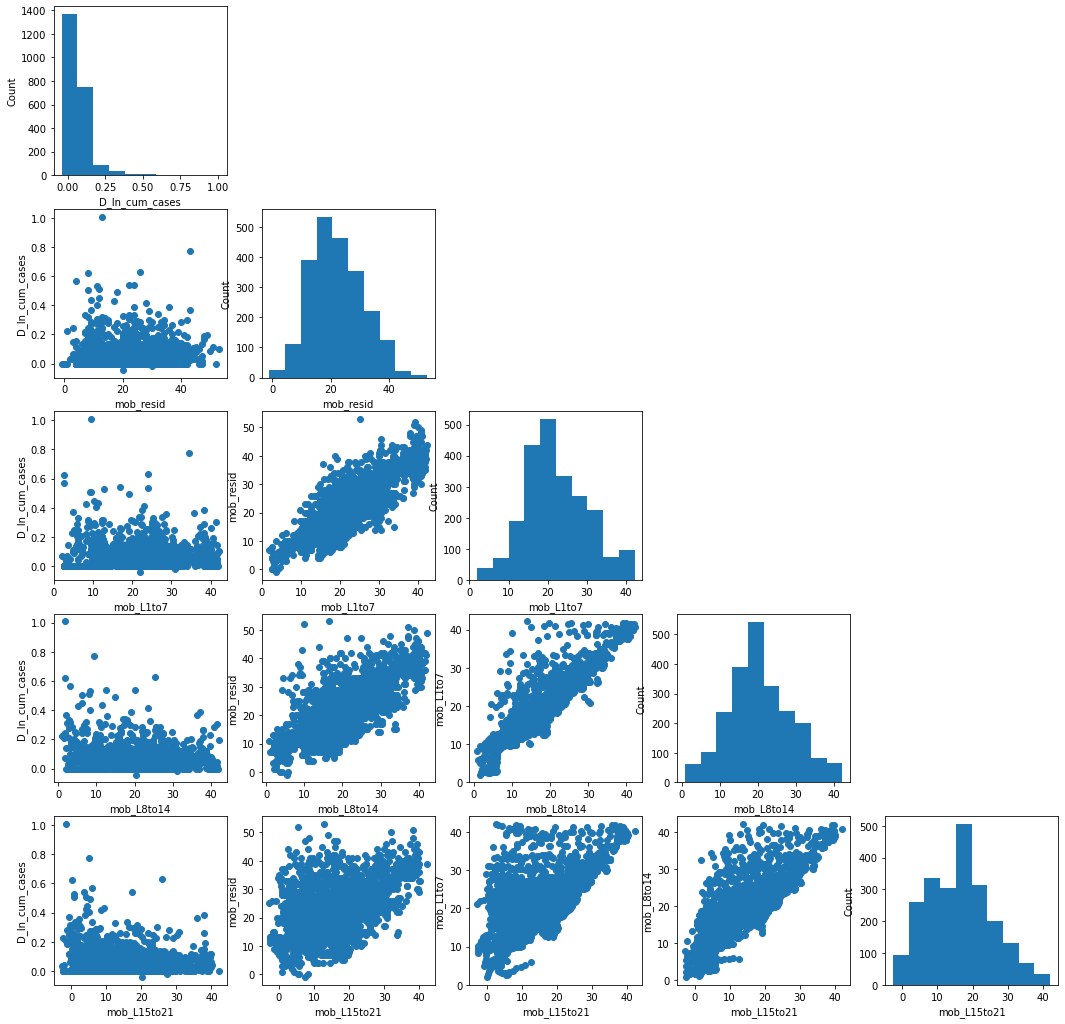

In [18]:
variables = ['D_ln_cum_cases', 'mob_resid','mob_L1to7', 'mob_L8to14', 'mob_L15to21']

scatterplotmatrix(
    df_train_b[variables].values,
    names=variables,
    figsize=(18,18), alpha=1
);

1. It appears that an increase in residential mobility 3 weeks ago leads to a lower growth rate of COVID-19 infections.

2. The four mobility variables seem to be normally distributed.

3. The distribution of the mobility features does not vary, so there is no need to scale (standardize/normalize) them **IF** one-hot encodings are **NOT** added to the model. SGD will fail if features are not normalized when one-hot encodings are added.

4. ML prediction does not require the outcome and feature variables to be normally distributed! This is a requirement for inference and hypothesis testing but not for predictive analysis! 

##### ``Step 5.2: Correlation matrix of outcome and feature variables``

Using the **heatmap** method in the **mlxtend** package we will now print the correltation matrix between the growth rate of COVID-19 cumulative cases and mobility features in the **mobility** model. (Hint: use df_train_b).

We will then answer the following questions:

1. Which mobility features seem to be most informative to predict the growth rate of COVID-19 infections?
2. What can you say about the correlation between the four mobility variables?

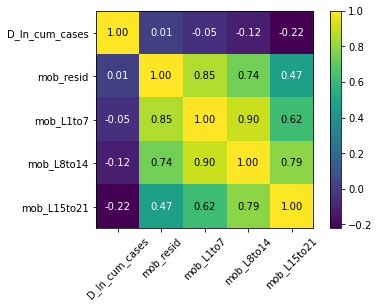

In [19]:
variables = ['D_ln_cum_cases', 'mob_resid', 'mob_L1to7', 'mob_L8to14', 'mob_L15to21']
cm = df_train_m[variables].corr().values
hm = heatmap(
    cm,
    row_names=variables,
    column_names=variables)

1. In general, we are interested in those features that have a high correlation with the target variable. We can see a relatively low correlation between mobility today (mob_resid) and the growth rate of Covid-19 cases. Is this surprising? Not really. It's very unlikely to see that an increase in residential mobility today affects the growth rate of cases today. Instead, looking at how changes in mobility 1,2,3 weeks ago affects the growth rate today is more informative.

2. The four mobility variables are positively correlated with values ranging between 0.47 and 0.90.

---
### Step 6: Analysis - linear regression (OLS)
---

The idea behind linear regression is to obtain the best-fitting straight line through the examples in the training data.

There are two ways you can fit the training data:
 - using a closed-form solution: $(X'X)^{-1}(X'y)$
 - using an iterative solution: gradient descent (stochastic, batch, etc.)

##### ``Step 6.2 Fit, predict and evaluate model performance using a closed-form solution``

Now that we have all data needed, we can fit, make predictions, and evaluate performance for the **baseline** and **mobility** models using a closed-form solution. We will use the **statsmodels** library for this exercise.

model fit 

In [20]:
# baseline model
baseline_fit = sm.OLS(y_train_b, X_train_b).fit()
#print(baseline_fit.summary())

# mobility model
mobility_fit = sm.OLS(y_train_m, X_train_m).fit() 
#print(mobility_fit.summary())

model prediction

In [21]:
# baseline model
baseline_yhat = baseline_fit.predict(X_test_b)

# nmobility model
mobility_yhat = mobility_fit.predict(X_test_m)

In [22]:
# add predicted growth rate to test dataframes for the two models (call it yhat)
df_test_b['yhat'] = baseline_yhat
df_test_m['yhat'] = mobility_yhat

# keep only cols of interest in test dataframes
cols = ['date', 'adm0_name', 'cum_cases', 'D_ln_cum_cases', 'yhat'] 
df_test_b = df_test_b[cols]
df_test_m = df_test_m[cols]

# for visualization purposes, print head of the baseline test df
df_test_b.head()

,date,adm0_name,cum_cases,D_ln_cum_cases,yhat
38,4-21,Afghanistan,1092,0.062343,0.084217
39,4-22,Afghanistan,1176,0.074108,0.101908
40,4-23,Afghanistan,1279,0.083960,0.097229
41,4-24,Afghanistan,1351,0.054767,0.091378
42,4-25,Afghanistan,1463,0.079644,0.081091


Our next task is to evaluate performance on the test data.

For each country and each day in the test sample of the **baseline** and **mobility** models, we will compute percentage error (compares actual vs. predicted values). Let's call this new variable "pct_error" and add it to df_test_b and df_test_m, respectively.  Finally, we will report MSE for both models and comment on model fit.

In [23]:
# compute percentage error: actual vs predicted values (for each date/country)
df_test_b['pct_error'] = ((df_test_b.yhat - df_test_b.D_ln_cum_cases))*100
df_test_m['pct_error'] = ((df_test_m.yhat - df_test_m.D_ln_cum_cases))*100

# compute mean square error (MSE) for each model
print(
    'MSE test baseline model:', np.mean(np.sqrt(df_test_b.yhat - df_test_b.D_ln_cum_cases))
)
print(
    'MSE test mobility model:', np.mean(np.sqrt(df_test_m.yhat - df_test_m.D_ln_cum_cases))
)

MSE test baseline model: 0.19073508239290654
MSE test mobility model: 0.1689802619594536


The mobility model seems to do better. However, one needs to do a cross-validation exercise on the train/test split period to accurately evaluate model performance.

Boxplot visualizations of the percentage error provide nice insights into model performance as well. Unlike MSE, which is aggregating the results acros countries and days, a  percentage error boxplot shows the distribution of predictions at the country/day level.

The plot below uses the **pct_error_plot()** function implemented at the top of the notebook.

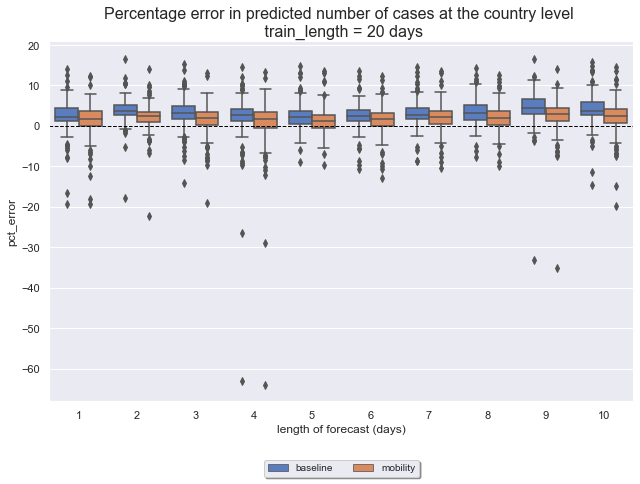

In [24]:
# plot boxplot and return combined df_test for baseline and mobility model
df_test_mb = pct_error_plot(
    df_test_b,
    df_test_m,
    'box',
    'closed_form'
)

You can now dive deeper into the predictive results of the two models to investigate what are the countries with the largest outliers. You can also play aroud with the pct_error threshold that you want to investigate.

In [25]:
print('It seems that',
      df_test_m[df_test_m.pct_error.le(-30)].adm0_name.unique(),
      'are outlier countries, i.e the pct_error is pretty high.'
     )

It seems that ['Ecuador' 'Tanzania'] are outlier countries, i.e the pct_error is pretty high.


##### ``Step 6.2 Fit, predict and evaluate model performance using an iterative solution``

Closed-form solutions find the optimal solution analytically, which is a good thing, but:
- if working with very large data sets, inveting the X'X matrix can be computationally very expensive
- X'X may be singular (not-invertible); this happens when two or more features are co-linear
- it cannot be used for regularization
- the linear model has a closed-form solution, but most other ML models don't have this luxury

An iterative solution like gradient descent can overcome these issues. 

We will now fit, predict and evaluate the performance of the **baseline** model using **TensorFlow**. We will use Keras API - it allows prototyping and building of models with just a few lines of codes, and it was developed with the idea to run on top of libraries such as TensorFlow. 

Our tasks are as follows:

1. Build and compile a TensorFlow model (use the **build_compile_tf_model()** function defined below)
2. Fit the TensorFlow model on the training data using a learning rate = [0.0001, 0.1] and 20 epochs of training
3. Predict growth rate of COVID-19 cumulative cases using the test data for each of the learning rates defined at point 2.
4. Evaluate performance of the model using the test data for each of the learning rates defined at point 2:
     * compute MSE. What learning rate leads to better performance of the model?
     * create a boxplot to show the pct_error of growth rates of COVID-19 cumulative cases at the country/day level. Our boxplot will compare pct_error using the TensorFlow solution (for both learning rates) and the pct_error using the closed-form solution. Which solution performs better?

In [26]:
def build_compile_tf_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. While this is intended for neural
    # networks (which may have multiple layers), we want just a single layer for
    # linear regression.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
          activation = None,           # linear activation is used
          units=1,                     # output dim
          input_shape=[num_features],  # input dim
          use_bias=False,              # do not use a bias (intercept) param (see how fixed effects have been added to the model)
          kernel_initializer=tf.ones_initializer,  # initialize params to 1
      ))
    
    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
    # SGD. We can specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse', 
    )
    
    return model

In [27]:
# define learning rates
learning_rates = [0.0001, 0.1]

# create dictionary to keep track of loss
growth_rate_mse_dict = {}

for idx, eta in enumerate(learning_rates):
    print('learning_rate:', eta)
    print('---------------------')
    
    # (1) Build and compile the baseline model #
    ############################################
    model_b = build_compile_tf_model(
        num_features=X_train_b.shape[1],
        learning_rate=eta
    )

    # (2) Fit the model using the train data #
    ##########################################
    baseline_fit_tf = model_b.fit(
      x = X_train_b,
      y = y_train_b,
      epochs=20,
      batch_size=1, #use all the data
      verbose=0) # silence the output
    
    # (3) Predict using the test data #
    ###################################
    baseline_yhat_tf = model_b.predict(X_test_b)
    
    # add predicted growth rate of COVID-19 cases to test dataframe
    df_test_b['yhat_tf'+'_'+str(eta)] = baseline_yhat_tf
    
    # (4) Evaluate performance of the model #
    ########################################
    # compute percentage error (for each date/country)
    df_test_b['pct_error_tf_'+str(eta)] = (
        (df_test_b['yhat_tf_'+str(eta)] - df_test_b.D_ln_cum_cases))*100
    
    # compute mean square error (MSE)
    print(
        'MSE baseline model:', np.mean(np.sqrt(df_test_b['yhat_tf_'+str(eta)] - df_test_b.D_ln_cum_cases)),
        '\n'
    )

learning_rate: 0.0001
---------------------
Metal device set to: Apple M1 Pro


2022-05-19 06:14:09.458993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 06:14:09.459438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-19 06:14:09.584747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 06:14:09.657555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 06:15:12.256931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 06:15:12.367143: I tensorflow/core/grappler/o

MSE baseline model: 0.7620689263755287 

learning_rate: 0.1
---------------------
MSE baseline model: 0.18439097930839127 



2022-05-19 06:16:13.361317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Interpretation: remember that the number of TF epochs is set to 20. In this case, a larger learning rate leads to better performance in the baseline model (MSE for learning rate=0.1 < MSE for learning rate = 0.0001)

Let's look at the percentage error boxplot next:

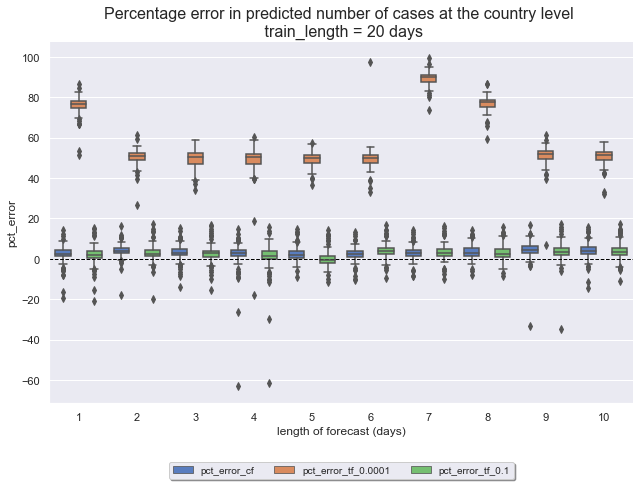

In [33]:
# boxplot of percentage error for baseline model
cols = [val for val in df_test_b if 'pct' in val]
df_test_b_tf = pd.melt(df_test_b,
        id_vars=['adm0_name', 'date'],
        var_name='model',
        value_vars=cols,
        value_name='pct_error')

# rename pct_error for closed-form baseline model as pct_error_cf 
df_test_b_tf['model'] = np.where(
    df_test_b_tf.model.eq('pct_error'), 'pct_error_cf', df_test_b_tf.model
)

df_test_b_tf = pct_error_plot(
    df_test_b_tf,
    df_test_m,
    'box',
    'tf'
)

In the plot above, the blue boxes represents pct_error using the closed-form solution. The orange and green boxes represent TensorFlow pct_errors for learning rates 0.0001 and 0.1, respetively.

With 20 training epochs, it seems that the closed-form solution and TensorFlow solution with learning rate 0.1 perform equally well. The TensorFlow solution with learning rate 0.0001 has a low performance (likely because 20 epochs is not sufficient given the small learning rate).

``How would your answers to the exercise above change if you set the number of training epochs to 200?``

In [34]:
# define learning rates
learning_rates = [0.0001, 0.1]

# create dictionary to keep track of loss
growth_rate_mse_dict = {}

for idx, eta in enumerate(learning_rates):
    print('learning_rate:', eta)
    print('---------------------')
    
    # (1) Build and compile the baseline model #
    ############################################
    model_b = build_compile_tf_model(
        num_features=X_train_b.shape[1],
        learning_rate=eta
    )

    # (2) Fit the model using the train data #
    ##########################################
    baseline_fit_tf = model_b.fit(
      x = X_train_b,
      y = y_train_b,
      epochs=200,
      batch_size=1, #use all the data
      verbose=0) # silence the output
    
    # (3) Predict using the test data #
    ###################################
    baseline_yhat_tf = model_b.predict(X_test_b)
    
    # add predicted growth rate of COVID-19 cases to test dataframe
    df_test_b['yhat_tf'+'_'+str(eta)] = baseline_yhat_tf
    
    # (4) Evaluate performance of the model #
    ########################################
    # compute percentage error (for each date/country)
    df_test_b['pct_error_tf_'+str(eta)] = (
        (df_test_b['yhat_tf_'+str(eta)] - df_test_b.D_ln_cum_cases))*100
    
    # compute mean square error (MSE)
    print(
        'MSE baseline model:', np.mean(np.sqrt(df_test_b['yhat_tf_'+str(eta)] - df_test_b.D_ln_cum_cases)),
        '\n'
    )

learning_rate: 0.0001
---------------------


2022-05-18 18:23:51.134923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-18 18:34:12.375796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-18 18:34:12.480453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


MSE baseline model: 0.2664668207316618 

learning_rate: 0.1
---------------------
MSE baseline model: 0.1972767412235538 



2022-05-18 18:44:33.150758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


A larger learning rate leads to better performance in the baseline model even when the number of training epochs is set to 200 (MSE for learning rate=0.1 < MSE for learning rate = 0.0001). The boxplot belows indicates this is likely because of noisy predictions in the 7 day of test.

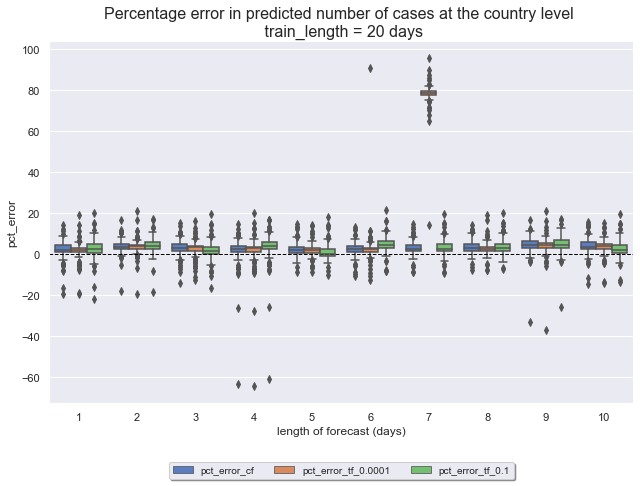

In [35]:
# boxplot of percentage error for baseline model
cols = [val for val in df_test_b if 'pct' in val]
df_test_b_tf = pd.melt(df_test_b,
        id_vars=['adm0_name', 'date'],
        var_name='model',
        value_vars=cols,
        value_name='pct_error')

# rename pct_error for closed-form baseline model as pct_error_cf 
df_test_b_tf['model'] = np.where(
    df_test_b_tf.model.eq('pct_error'), 'pct_error_cf', df_test_b_tf.model
)

df_test_b_tf = pct_error_plot(
    df_test_b_tf,
    df_test_m,
    'box',
    'tf'
)

With 200 training epochs, it seems that the closed-form solution and TensorFlow solutions with learning rates 0.0001 and 0.1, respectively perform equally well on average for all days of test except day=7. The TensorFlow solution with learning rate 0.0001 has a low performance on the 7 day, it will be worth investigating why.

---
#### References
---

This Demo was motivated by a recently published paper in Nature - Scientific Reports: [Public mobility data enables COVID-19 forecasting and management at local and global scales](https://www.nature.com/articles/s41598-021-92892-8). 